# Projet Stratégies d'Investissement Alternatives et Quantitatives
## Jérémy Bellina, Joël Zhu

# Libraries

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Data

In [69]:
# load the crypto prices csv data
crypto_prices = pd.read_csv("crypto_prices.csv", parse_dates=[0])
crypto_prices.set_index('date', inplace=True)

# load the CRIX index csv data
crix_prices = pd.read_csv("vcrix.csv", parse_dates=[0])
crix_prices.set_index('date', inplace=True)
crix_prices = crix_prices.drop(["Unnamed: 0", "n"], axis=1)
crix_prices = crix_prices.loc["2018-04-01":"2020-05-26"]

# load the Fama & French momentum factor csv data
FFMomentum = pd.read_csv("F-F_Momentum_Factor_daily.CSV", parse_dates=[0])
FFMomentum = FFMomentum.rename(columns={'Unnamed: 0': 'date'})
FFMomentum.set_index('date', inplace=True)
FFMomentum = FFMomentum.loc["2018-04-01":]

# load the Fama & French research data factor csv data
FFResearch = pd.read_csv("F-F_Research_Data_Factors_daily.CSV", parse_dates=[0])
FFResearch = FFResearch.rename(columns={'Unnamed: 0': 'date'})
FFResearch.set_index('date', inplace=True)
FFResearch = FFResearch.loc["2018-04-01":]

In [70]:
formatted_dates = pd.date_range(start = "2018-04-01", end = "2020-05-26")
rebalancing_dates = pd.date_range(start = "2018-04-01", end = "2020-05-01", freq = pd.DateOffset(months=1, day=1))
horizon = 15
initial_value = 100

# Helper functions

In [71]:
def sort_returns(current_date, data):
    date = str(current_date.date())
    return data.loc[date].sort_values(ascending=False)

In [72]:
def compute_value(date, portfolio, crypto_prices):
    value = 0
    for item in portfolio:
        value += item[1] * crypto_prices.loc[date, item[0]]
    return value

In [73]:
def update_portfolio(amount, data, date, crypto_names):
    portfolio = []
    for name in crypto_names:
        portfolio.append((name, amount / data.loc[date, name]))
    return portfolio

# Backtest functions

Creates portfolio long on all crypto currencies **equally weighted**

In [74]:
def get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, data, portfolio_index):
    values = [initial_value]
    returns = data.pct_change(periods=horizon)
    portfolio = []
    for date in formatted_dates:
        if str(date) != "2018-04-01 00:00:00":
            values.append(compute_value(date, portfolio, data)) # update values
        if date in rebalancing_dates:
            sorted_returns = sort_returns(date, returns) # sort returns for the rebalancing date
            crypto_names = sorted_returns.iloc[(10 * (portfolio_index - 1)):(10 * portfolio_index)].index # extract names from data
            portfolio = update_portfolio(values[-1] / 10, data, date, crypto_names) # update composition
    return values

Creates a portfolio **long on best returns** crypto currencies and **short on lowest returns** ones

In [75]:
 def long_short_strategy(ptf_values1, ptf_values5):
    values = []
    for value1, value5 in zip(ptf_values1, ptf_values5):
        values.append(value1 - value5)
    return values

# Portfolio initializations

In [76]:
# P1, P2, P3, P4, P5
portfolios_df = pd.DataFrame()

portfolios_df["date"] = formatted_dates
portfolios_df.set_index('date', inplace=True) # set as index so that it is easier to plot

for i in range(5):
    pf_index = 1+i
    portfolios_df["P"+str(pf_index)] = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, pf_index)

In [77]:
# Long-short strategy
ptf_values1 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values5 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)
long_short = long_short_strategy(ptf_values1, ptf_values5)

long_short_df = pd.DataFrame(data = {'date': formatted_dates, 'P1-P5': long_short})
long_short_df.set_index('date', inplace=True)

# Plot 

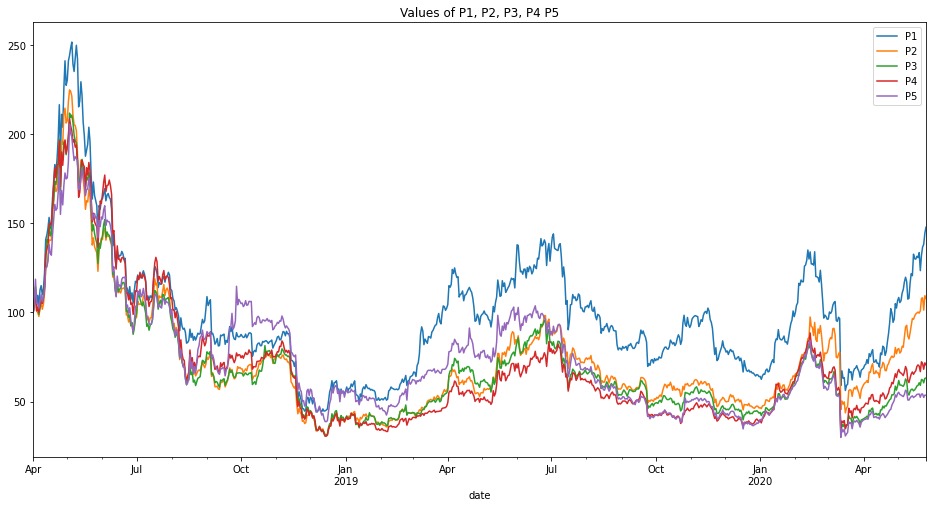

In [78]:
portfolios_df.plot(figsize=(16,8), title="Values of P1, P2, P3, P4 P5")

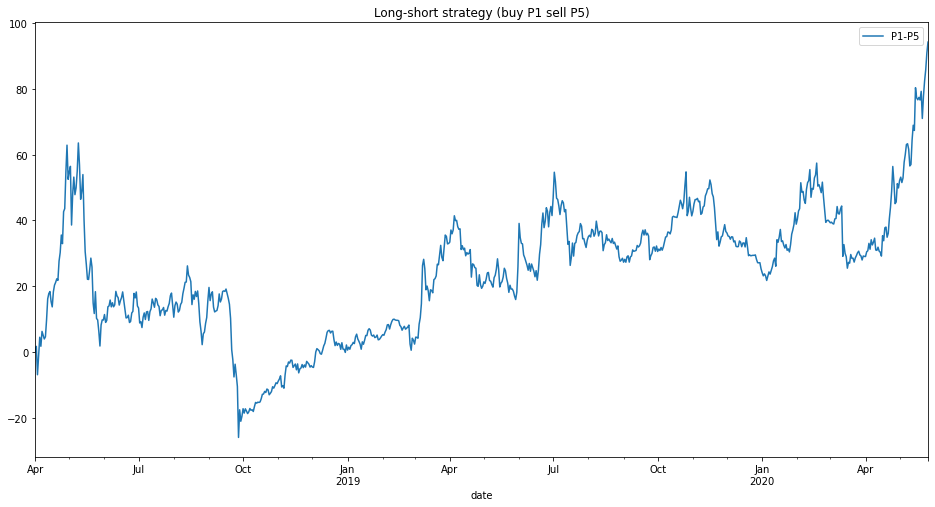

In [79]:
long_short_df.plot(figsize=(16,8), title="Long-short strategy (buy P1 sell P5)")

# Statistical description

## Initialization

In [80]:
# P1 to P5
portfolios_df_returns = portfolios_df.pct_change()

In [81]:
# Long-short strategy
long_short_df_returns = long_short_df.pct_change()

def winsorizing(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    minimum  = q1-1.5*iqr
    maximum = q3+1.5*iqr
    return df.loc[(df[col] > minimum) & (df[col] < maximum)]

long_short_df_returns = winsorizing(long_short_df_returns, 'P1-P5')

## Mean

In [82]:
# P1, P2, P3, P4, P5
portfolios_df_returns.mean()

P1    0.001651
P2    0.001213
P3    0.000491
P4    0.000686
P5    0.000440
dtype: float64

Interprétation : Le rendement moyen journalier du portefeuille P1 est 0.165%. Il est plus élevé que tous les autres portefeuilles momentum. Cela est cohérent car le portefeuille P1 est constitué des crypto-monnaies ayant la plus forte croissance à chaque date de rebalancement. Il semble donc que la stratégie momentum fonctionne.

In [83]:
# Long-short strategy
long_short_df_returns.mean()

P1-P5    0.00499
dtype: float64

Interprétation : Le rendement moyen journalier de la stratégie 'acheter P1 et vendre P5' est proche de 0.5%. Cela est beaucoup plus élevé que le rendement moyen de P1. C'est un signe positif qui indique que la stratégie semble fonctionner.

## Standard deviation

In [84]:
# P1, P2, P3, P4, P5
portfolios_df_returns.std()

P1    0.047095
P2    0.046147
P3    0.045343
P4    0.046768
P5    0.048832
dtype: float64

Interprétation : Les écart-types ne sont pas significativement éloignés les uns des autres pour pouvoir dire qu'un portefeuille est plus risqué qu'un autre. On peut donc supposer que les portefeuilles de crypto-monnaies sont tous exposés à un risque de marché similaire important (celui des crypto-monnaies) mais que les portefeuilles sont suffisament diversifiés au sein de ce marché pour ne subir qu'un risque spécifique faible.

In [85]:
# Long-short strategy
long_short_df_returns.std()

P1-P5    0.09213
dtype: float64

Interprétation : L'écart-type de la stratégie est presque 2x plus élevé que le portefeuille P1. On peut donc expliquer en partie le rendement plus élevé de cet stratégie par un risque beaucoup plus grand.

## Median

In [86]:
# P1, P2, P3, P4, P5
portfolios_df_returns.median()

P1    0.003487
P2    0.002854
P3    0.002478
P4    0.003057
P5    0.003053
dtype: float64

Interprétation : Les médianes sont bien plus élevées que les moyennes. Les rendements journaliers négatifs sont donc beaucoup plus importants en valeur absolue que les rendement positifs.

In [87]:
# Long-short strategy
long_short_df_returns.median()

P1-P5    0.005939
dtype: float64

Interprétation : La médiane est plus élevée que pour le P1. Cela semble cohérent avec le fait que la rentabilité moyenne soit également plus élevée.

## Minimum

In [88]:
# P1, P2, P3, P4, P5
portfolios_df_returns.min()

P1   -0.388953
P2   -0.414802
P3   -0.398284
P4   -0.385747
P5   -0.426499
dtype: float64

Interprétation : Durant sa pire journée, le portefeuille P1 a subit une baisse de -38.90% de sa valeur. Cela est très important mais reste néanmoins légerement moins que les autres portefeuilles (à l'exception du P4).

In [89]:
# Long-short strategy
long_short_df_returns.min()

P1-P5   -0.243114
dtype: float64

Interprétation : Le minimum de la stratégie est plus faible que celui de P1. C'est un signe positif qui indique que cette stratégie permet d'amortir les variations fortes du marché. 

A noter : Ce résultat est à relativiser car on effectue une winsorisation qui élimine certaines valeurs extrêmes.

## Maximum

In [90]:
# P1, P2, P3, P4, P5
portfolios_df_returns.max()

P1    0.153043
P2    0.186089
P3    0.168602
P4    0.252157
P5    0.210899
dtype: float64

Interprétation : Durant sa meilleure journée, le portefeuille P1 a vu sa valeur monter de 15.30%. C'est impressionant mais plus faible que les autres portefeuiles qui atteignent jusqu'à 25.22%. Durant des périodes à fortes variations, le portefeuille P1 subit des gains et des pertes moins importantes que ses homologues. On pourra donc s'attendre à un Béta plus faible.

In [91]:
# Long-short strategy
long_short_df_returns.max()

P1-P5    0.257673
dtype: float64

Interprétation : Même avec la winsorisation, le maximum est nettement plus élevé que P1. C'est également un bon signe car cette stratégie permettrait donc d'amortir les variations à la baisse et amplifier les variations à la hausse.

## Skewness

In [92]:
# P1, P2, P3, P4, P5
portfolios_df_returns.skew(axis=0)

P1   -0.938847
P2   -1.129604
P3   -1.027596
P4   -0.639909
P5   -0.567365
dtype: float64

Interprétation : La skewness de tous les portefeuilles est négative. Cette statistique indique que la distribution est asymétrique et que la queue de la distribution est plus longue vers les rendements inférieurs à la moyenne. 
Pour les portefeuilles P1 à P5, la distribution est modéremment voire fortement skewed négativement.
Cela est confirmée par le fait que la moyenne soit inférieure à la médiane. 

In [93]:
# Long-short strategy
long_short_df_returns.skew(axis=0)

P1-P5   -0.04049
dtype: float64

Interprétation : La skewness de la stratégie est proche de 0. La distribution est donc quasiment symétrique.
Cela est également logique car la différence entre la moyenne et la médiane est plus faible pour la stratégie que pour les portefeuilles individuels.

## Kurtosis

In [94]:
# P1, P2, P3, P4, P5
portfolios_df_returns.kurtosis(axis=0)

P1    7.182078
P2    9.462124
P3    8.739581
P4    8.008115
P5    9.388953
dtype: float64

Interprétation : Les Kurtosis sont plus grandes que 3. La distribution est donc leptokurtique qui indique qu'une grande partie des rentabilités est concentrée autour de la moyenne.

In [95]:
# Long-short strategy
long_short_df_returns.kurtosis(axis=0)

P1-P5    0.308785
dtype: float64

Interprétation : Le kurtosis est inférieur à 3. La distribution est platykurtique ce qui signifie que la distribution est plate et donc les valeurs ne sont pas concentrées autour de la moyenne mais plus étalées.

## Global interpretation

- P1-5 bons rendements moyens médian max donc bonne strat
- mais plus risquée car stddev grande et kurtosis < 3 donc rendements étalés et pas forcément proches de la moyenne
- donc mesures de perf pour voir lequel est le meilleur ptf
- très dépendant des paramètres notamment de horizon

# Performance measures

## Initialization

In [96]:
def fill_missing_values(dataframe, dates):
    # We use a list of dates to ensure that we have all the dates we want in the dataframe
    dataframe = dataframe.reindex(dates)
    # We use the last valid value to fill the NaN created 
    dataframe = dataframe.fillna(method='ffill')
    # We use the next valid value to fill the first row of NaN
    dataframe = dataframe.fillna(method='bfill')
    return dataframe

# We fill the missing dates of FFResearch 
FFResearch_filled = fill_missing_values(FFResearch, formatted_dates)

# We fill the missing dates of FFMomentum
FFMomentum_filled = fill_missing_values(FFMomentum, formatted_dates)

# We fill the first value of portfolios_df_returns which is NaN
portfolios_df_returns_filled = fill_missing_values(portfolios_df_returns, formatted_dates)
long_short_df_returns_filled = fill_missing_values(long_short_df_returns, formatted_dates)

# We compute R-Rf for all portfolios
R_RF = portfolios_df_returns_filled.sub(FFResearch_filled["RF"], axis=0)
long_short_RF = long_short_df_returns_filled.sub(FFResearch_filled["RF"], axis=0)

# We handle crix values
crix_returns = crix_prices.pct_change()
crix_returns_filled = fill_missing_values(crix_returns, formatted_dates)
RM_RF = (crix_returns["vcrix"] - FFResearch_filled['RF'])

## Sharpe

In [97]:
print(R_RF)
print(long_short_RF.mean()/long_short_df_returns_filled.std())

                  P1        P2        P3        P4        P5
2018-04-01  0.059990  0.046038  0.046509  0.038775  0.043074
2018-04-02  0.059990  0.046038  0.046509  0.038775  0.043074
2018-04-03  0.039940  0.074172  0.079693  0.066560  0.122797
2018-04-04 -0.074984 -0.119709 -0.112364 -0.108133 -0.121065
2018-04-05  0.045866 -0.018679 -0.007750  0.014336 -0.006659
...              ...       ...       ...       ...       ...
2020-05-22  0.069486  0.069420  0.055698  0.082949  0.034701
2020-05-23  0.035204  0.003026 -0.003508 -0.013695  0.000524
2020-05-24  0.011018 -0.063924 -0.026580 -0.045029 -0.035987
2020-05-25  0.046241  0.079814  0.042083  0.053142  0.024934
2020-05-26  0.022618 -0.014067  0.002795 -0.015755 -0.000826

[787 rows x 5 columns]
P1-P5   -0.085774
dtype: float64


## Treynor et Jensen

In [98]:
intercept = sm.add_constant(FFResearch_filled["Mkt-RF"])

### P1

In [99]:
reg = sm.OLS(R_RF["P1"], intercept).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     P1   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     23.28
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           1.68e-06
Time:                        11:18:25   Log-Likelihood:                 1296.6
No. Observations:                 787   AIC:                            -2589.
Df Residuals:                     785   BIC:                            -2580.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.002     -3.262      0.001      -0.009      -0.002
Mkt-RF         0.0053      0.001      4.825      0.000       0.003       0.007
==============================================================================
Omnibus:                      138.791   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              746.945
Skew:                          -0.677   Prob(JB):                    6.35e-163
Kurtosis:                       7.577   Cond. No.                         1.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### P2

In [100]:
reg = sm.OLS(R_RF["P2"], intercept).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     P2   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     27.70
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           1.83e-07
Time:                        11:18:25   Log-Likelihood:                 1315.3
No. Observations:                 787   AIC:                            -2627.
Df Residuals:                     785   BIC:                            -2617.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.002     -3.616      0.000      -0.009      -0.003
Mkt-RF         0.0056      0.001      5.263      0.000       0.004       0.008
==============================================================================
Omnibus:                      174.368   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1239.313
Skew:                          -0.801   Prob(JB):                    7.70e-270
Kurtosis:                       8.935   Cond. No.                         1.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### P3

In [101]:
reg = sm.OLS(R_RF["P3"], intercept).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     P3   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     30.87
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           3.78e-08
Time:                        11:18:25   Log-Likelihood:                 1331.3
No. Observations:                 787   AIC:                            -2659.
Df Residuals:                     785   BIC:                            -2649.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.002     -4.142      0.000      -0.010      -0.003
Mkt-RF         0.0058      0.001      5.556      0.000       0.004       0.008
==============================================================================
Omnibus:                      162.985   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1020.612
Skew:                          -0.773   Prob(JB):                    2.38e-222
Kurtosis:                       8.360   Cond. No.                         1.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### P4

In [102]:
reg = sm.OLS(R_RF["P4"], intercept).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     P4   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     34.22
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           7.23e-09
Time:                        11:18:25   Log-Likelihood:                 1308.5
No. Observations:                 787   AIC:                            -2613.
Df Residuals:                     785   BIC:                            -2604.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0064      0.002     -3.905      0.000      -0.010      -0.003
Mkt-RF         0.0063      0.001      5.850      0.000       0.004       0.008
==============================================================================
Omnibus:                      112.755   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              885.490
Skew:                          -0.362   Prob(JB):                    5.23e-193
Kurtosis:                       8.146   Cond. No.                         1.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### P5

In [103]:
reg = sm.OLS(R_RF["P5"], intercept).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     P5   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     26.24
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           3.80e-07
Time:                        11:18:25   Log-Likelihood:                 1271.3
No. Observations:                 787   AIC:                            -2539.
Df Residuals:                     785   BIC:                            -2529.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.002     -3.870      0.000      -0.010      -0.003
Mkt-RF         0.0058      0.001      5.122      0.000       0.004       0.008
==============================================================================
Omnibus:                      124.219   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1294.206
Skew:                          -0.323   Prob(JB):                    9.26e-282
Kurtosis:                       9.249   Cond. No.                         1.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### P1-5

In [104]:
reg = sm.OLS(long_short_RF, intercept).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  P1-P5   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.963
Date:                Sat, 06 Mar 2021   Prob (F-statistic):              0.162
Time:                        11:18:25   Log-Likelihood:                 719.47
No. Observations:                 787   AIC:                            -1435.
Df Residuals:                     785   BIC:                            -1426.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0083      0.003     -2.387      0.017      -0.015      -0.001
Mkt-RF         0.0032      0.002      1.401      0.162      -0.001       0.008
==============================================================================
Omnibus:                        1.351   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                1.226
Skew:                          -0.090   Prob(JB):                        0.542
Kurtosis:                       3.069   Cond. No.                         1.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""